In [184]:
# Import libraries
import numpy as np
import scipy as sp
import scipy.linalg as la
import scipy.stats as st
import matplotlib
import matplotlib.cm as cm
import yfinance as yf #import finance data from Yahoo Finance
import pandas as pd #import pandas to manipulate Yahoo Finance data

from matplotlib.image import imread
from scipy.io import wavfile
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
from scipy.signal import stft
from numpy.random import multivariate_normal as mv_norm

In [185]:
def kalman(stk_data, hist):
    X = np.empty([len(stk_data)+1])

    A = 1 #transition matrix 
    P = 1 #certainty matrix
    qt = 0.1 #process noise
    rt = 0.1 #measurement noise
    step = 1
    X[0] = stk_data[0] #initialize first value

    for it in range(1,len(stk_data)+1):
        #predict
        if it > hist:
            qt = np.var(stk_data[it-hist:it-1])
        
        X[it] = A*stk_data[it-step] + np.random.normal(0,qt)
        P = P + np.random.normal(0,qt)
    
        #update/correct
        K = P/((P + np.random.normal(0,rt))) #Kalman gain
        iterations = 0 #initialize
        while X[it-step]+K*(X[it]-X[it-step]) < 0: #no negative stock prices
            K = P/((P + np.random.normal(0,rt))) #recompute Kalman gain to satisfy constraints 
            X[it] = X[it-step]+K*(X[it]-X[it-step])
            iterations += 1
            if iterations > 10:
                break
        P = (1-K)*P

    return X

In [210]:
#define the ticker symbol
tickerSym =  'NDAQ' #'VTI' #'NDAQ' #'AAPL' #'TSLA'

#get data on this ticker
tickerData = yf.Ticker(tickerSym)

#get the historical prices for this ticker
#tickerDf = tickerData.history(period='1w', start='2011-1-1', end='2021-1-1')
tickerDf = tickerData.history(period='1d', start='2011-1-1', end='2021-1-1')

#see your data
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2011-01-03,20.440162,20.695771,20.406082,20.542406,1358100,0.0,0
2011-01-04,20.542406,20.695771,20.337919,20.380520,1960500,0.0,0
2011-01-05,20.337924,20.397566,20.150476,20.150476,2215000,0.0,0
2011-01-06,20.124915,20.218637,19.911908,20.065271,1959600,0.0,0
2011-01-07,20.176029,20.210109,19.809657,19.920420,1773200,0.0,0
...,...,...,...,...,...,...,...
2020-12-24,126.792924,127.545876,126.406534,127.426979,191800,0.0,0
2020-12-28,127.882716,128.021417,126.733472,127.654854,458700,0.0,0
2020-12-29,128.447426,128.665386,127.704382,127.942162,303600,0.0,0


(2517, 7)
<class 'pandas.core.frame.DataFrame'>


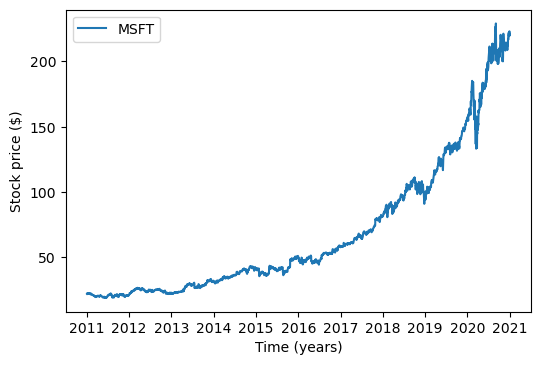

In [211]:
print(tickerDf.shape)
print(type(tickerDf))
stk_data = tickerDf["Close"]

#define the ticker symbol
tickerSym2 = 'MSFT' #''NDAQ' #'AAPL' #'TSLA'

#get data on this ticker
tickerData2 = yf.Ticker(tickerSym2)

#get the historical prices for this ticker
#tickerDf = tickerData.history(period='1w', start='2011-1-1', end='2021-1-1')
tickerDf2 = tickerData2.history(period='1d', start='2011-1-1', end='2021-1-1')

stk_data2 = tickerDf2["Close"]

# plot results
fig = plt.figure()
#plt.plot(stk_data, label ='')
plt.plot(stk_data2, label ='MSFT')
plt.xlabel('Time (years)')
plt.ylabel('Stock price ($)')
plt.legend()

fig.set_dpi(100)

0.7143440341728948
2.114980651748286
R-squared avg: 0.990733
-0.01886044194407736


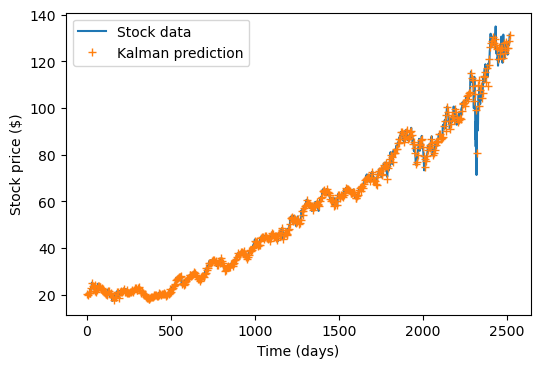

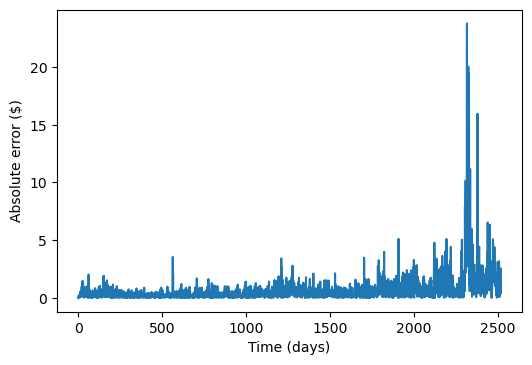

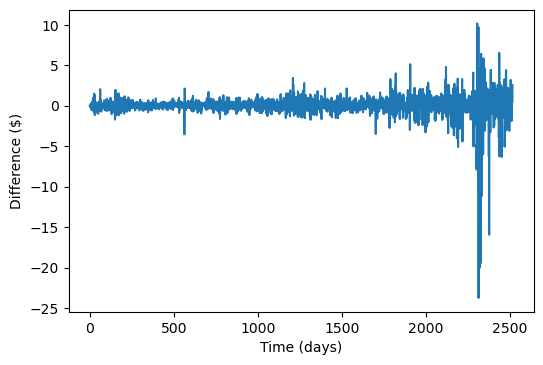

In [213]:
stk_data = tickerDf["Close"]

num_it = 100
mae_tally = np.empty([num_it])
rmse_tally = np.empty([num_it])
Rsq = np.empty([num_it])

for it in range(0,num_it):
    X = kalman(stk_data,3) # apply Kalman filter

    #compute accuracy
    mid_val = (X[0:len(stk_data)] + stk_data)/2
    abs_diff = np.abs(stk_data - X[0:len(stk_data)])

    mae = np.mean(abs_diff) #mean absolute error
    rmse = np.sqrt(np.mean((stk_data - X[0:len(stk_data)])**2)) #root mean sq error
    res = st.linregress(X[0:len(stk_data)],stk_data)

    mae_tally[it] = mae
    rmse_tally[it] = rmse
    Rsq[it] = res.rvalue**2

time1 = np.arange(0,len(stk_data))
time2 = np.arange(0,len(stk_data)+1)

sparse = np.linspace(0,len(stk_data), int((len(stk_data))/5), dtype=int)

# plot results
fig = plt.figure()
plt.plot(time1, stk_data, label = 'Stock data')
plt.plot(time2[(sparse)], X[(sparse)], '+', label = 'Kalman prediction')
plt.xlabel('Time (days)')
plt.ylabel('Stock price ($)')
plt.legend()
fig.set_dpi(100)

# plot results
fig = plt.figure()
plt.plot(time1, (abs_diff))
plt.xlabel('Time (days)')
plt.ylabel('Absolute error ($)')
fig.set_dpi(100)

# plot results
fig = plt.figure()
plt.plot(time1, (stk_data - X[0:len(stk_data)]))
plt.xlabel('Time (days)')
plt.ylabel('Difference ($)')
fig.set_dpi(100)

mae_avg = np.mean(mae_tally)
rmse_avg = np.mean(rmse_tally)
Rsq_avg = np.mean(Rsq)


print(mae_avg)
print(rmse_avg)
print(f"R-squared avg: {Rsq_avg:.6f}")
print(np.mean(stk_data - X[0:len(stk_data)]))


In [138]:
# LSTM RNN



In [193]:
print(len(stk_data))
print(sparse)

62
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 62]
